# KNN 

This document is dedicated to KNN model experienments. 

KNN comes with the "Curse of high dimensionality", so we will focus on the model working on only the personal features. 

In [1]:
import pandas as pd
# from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
import importlib
import sys 
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA, KNeighborsClassifier as KNN  
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.linear_model import LogisticRegression

sys.path.append("../")

from proj_mod import visualization, data_processing, training 
importlib.reload(visualization);
importlib.reload(data_processing);
importlib.reload(training); 

# from joblib import dump, load
import cloudpickle as cp

seed=420

In [2]:
df=pd.read_csv("../data/raw.csv")
df["y"]=df["y"].map({"no": 0, "yes": 1})
features=df.columns[:-1]
df_feat=df[features]
# df_feat["month_num"]=df_feat["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}).to_numpy().astype(int)
# df_feat["day_of_year"]=data_processing.day_of_non_leap_np(month_arr=df_feat["month_num"].to_numpy(), day_arr=df_feat["day"].to_numpy()).astype(int)
df_tar=df[["y"]]

## With only the personal features 

### Oversampler 

In [16]:
dt=data_processing.data_transform(cam1=False, cam2=False)
ds=data_processing.data_selector(cut=0.95, how="mi score")
p=Pipeline([
    ("dt",dt),
    ("ds",ds)
])
p.fit(X=df_feat,y=df_tar)
p.transform(X=df_feat)

,age,age_tar,marital_married,balance_tar,balance,job_tar,education,marital_single,education_tar,job_services,housing_yes,job_management,job_blue-collar,loan_yes,job_retired,job_unemployed,job_housemaid,job_student,job_self-employed,job_unknown,job_technician,job_entrepreneur,default_yes
0,58,7.659174,1.0,9.597768,7.670475,8.278227,3,0.0,9.182581,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,6.252218,0.0,5.423260,3.404525,7.253357,2,1.0,6.754632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,7.665756,1.0,5.575723,1.131402,6.263345,2,0.0,6.754632,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47,5.969079,1.0,7.965275,7.317943,5.701801,1,0.0,6.270411,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,7.665756,0.0,5.683893,0.741937,7.234043,1,1.0,6.270411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,5.766354,1.0,6.878299,5.981667,7.253357,3,0.0,9.182581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39996,30,8.872931,0.0,13.699589,8.114055,8.278227,3,1.0,9.182581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39997,54,5.552559,0.0,6.261347,5.303802,7.829578,2,0.0,6.754632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39998,34,7.268098,1.0,7.757697,6.954734,8.278227,3,0.0,9.182581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pipe=Pipeline([
    ("data_transform", data_processing.data_transform(cam1=False, cam2=False)), 
    ("data_select", data_processing.data_selector(cut=0.95, how="mi score")), 
    ("Oversampling", RandomOverSampler(sampling_strategy="auto", random_state=seed)), 
    ("scaler", StandardScaler()), 
    ("PCA", PCA(random_state=seed)), 
    ("NCA", NCA(init="identity", random_state=seed)), 
    ("KNN", KNN())
])

param_dict={
    "PCA__n_components": [0.95, 0.98, 0.99, None],
    "PCA__whiten": [False, True],
    
    "NCA__n_components": [None, 8, 12, 16], 
    
    "KNN__n_neighbors": [5, 9, 15, 25, 35], 
    "KNN__weights": ["uniform", "distance"],
    "KNN__metric": ["minkowski"], 
    "KNN__p": [1, 2], 
    "KNN__leaf_size": [15, 30, 45]
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [18]:
model_eval_per=training.model_eval(search_method="Random", search_cv_n_jobs=8, searech_verbose=3, random_search_n_iter=30)

WARNING: EVEN 32G of RAM CAN NOT RUN THIS !!!!!!!!! 

In [ ]:
model_eval_per.eval(df_feat=df_feat, df_tar=df_tar, outer_cv=outer_split, param_dict=param_dict, pipe=pipe)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Due to hardware (ram) limits, this experiment has to end here. 

### Undersampler (simple)

In [6]:
pipe=Pipeline([
    ("data_transform", data_processing.data_transform(cam1=False, cam2=False)), 
    ("data_select", data_processing.data_selector(cut=0.95, how="mi score")), 
    ("undersampling", RandomUnderSampler(sampling_strategy="auto", random_state=seed)), 
    ("scaler", StandardScaler()), 
    ("PCA", PCA(random_state=seed)), 
    ("NCA", NCA(init="identity", random_state=seed)), 
    ("KNN", KNN())
])

param_dict={
    "PCA__n_components": [0.95, 0.98, 0.99, None],
    "PCA__whiten": [False, True],
    
    "NCA__n_components": [None, 8, 12, 16], 
    
    "KNN__n_neighbors": [5, 9, 15, 25, 35], 
    "KNN__weights": ["uniform","distance"],
    "KNN__metric": ["minkowski"], 
    "KNN__p": [1, 2], 
    "KNN__leaf_size": [15, 30, 45]
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [7]:
model_eval_per_US=training.model_eval(search_method="Random", search_cv_n_jobs=8, searech_verbose=3, random_search_n_iter=15)

In [8]:
model_eval_per_US.eval(df_feat=df_feat, df_tar=df_tar, outer_cv=outer_split, param_dict=param_dict, pipe=pipe)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 3/5] END KNN__leaf_size=30, KNN__metric=minkowski, KNN__n_neighbors=25, KNN__p=2, KNN__weights=uniform, NCA__n_components=8, PCA__n_components=0.95, PCA__whiten=False; average_precision: (test=0.114) f1: (test=0.153) roc_auc: (test=0.582) total time= 1.3min
[CV 4/5] END KNN__leaf_size=30, KNN__metric=minkowski, KNN__n_neighbors=15, KNN__p=1, KNN__weights=distance, NCA__n_components=12, PCA__n_components=0.95, PCA__whiten=True; average_precision: (test=0.111) f1: (test=0.152) roc_auc: (test=0.583) total time= 1.6min
[CV 1/5] END KNN__leaf_size=30, KNN__metric=minkowski, KNN__n_neighbors=15, KNN__p=1, KNN__weights=distance, NCA__n_components=12, PCA__n_components=0.95, PCA__whiten=True; average_precision: (test=0.112) f1: (test=0.148) roc_auc: (test=0.562) total time= 1.6min
[CV 2/5] END KNN__leaf_size=30, KNN__metric=minkowski, KNN__n_neighbors=25, KNN__p=2, KNN__weights=uniform, NCA__n_components=8, PCA__n_components=0.95

In [9]:
model_eval_per_US.save_dict(save_path="../data/fitted/knn/compressed_fitted_dict_per_US_knn_run1.gz", compress=True)

Data pickled
Data compressed
Fitted dictionary saved


In [10]:
model_eval_per_US.confusion_data_by_threshold(y=df_tar, outer_cv=outer_split)

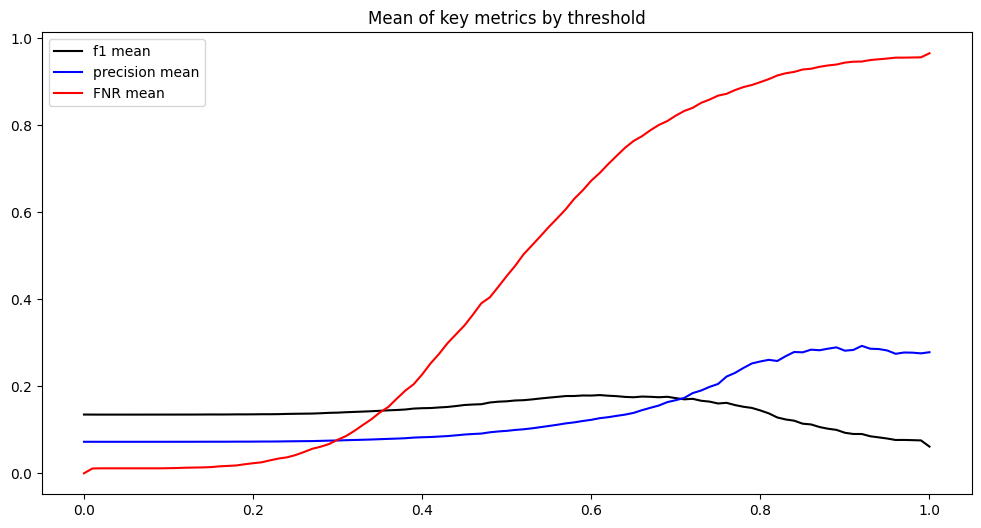

In [11]:
model_eval_per_US.create_visual()

In [12]:
model_eval_per_US.eval_metrics_

{'f1': np.float64(0.1654641065014093),
 'roc_auc': np.float64(0.6058415352100049),
 'ap': np.float64(0.12670032436673698)}

Pretty bad. 